# YOFO - You Only Fisheye Once

Pipeline for Localize fisheye image using global descriptor

In [1]:
# Check if we have NVIDIA Driver installed !
!nvidia-smi

Thu Mar 14 08:18:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:08:00.0 Off |                  N/A |
|  0%   43C    P8              45W / 420W |    107MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Stuff

In [2]:
# Imports
# Date Time
from dateutil import tz
from datetime import datetime

# Libraries
import sys
import os
import copy
import json
import numpy as np
import shutil
import PIL

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, metrics

# PYTORCH !
import torch
import torchinfo
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Visualization
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# Path for Import Internal Modules
sys.path.append("/workspace/fisheye-vpr")


2024-03-14 08:18:37.496695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 08:18:37.944544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Fix Seed for Regeneration

In [3]:
## Fix Seed for Regeneration
torch.manual_seed(777)

---

### Import Model

In [4]:
# Main Model
from models.vpr_model import VPRModel

# Feature Extractor
from models.encoders.resnet18 import Resnet18Encoder
from models.encoders.vgg16 import VGG16Encoder

# Clustering
from models.clustering.netvlad import NetVLAD

# Loss
from models.loss_function.HardTripletLoss import HardTripletLoss

# Trainer
from util.train import Trainer

### Dataset Selection

In [5]:
# from dataloaders.isl2_3places_fisheye import ISL2_3Places_Fisheye_Dataset
# dataset = ISL2_3Places_Fisheye_Dataset()

In [6]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

### Exploring Dataset

In [7]:
import matplotlib.pyplot as plt

In [8]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type))
    BSIZE = 8
    figsize=(BSIZE, BSIZE)
    # loop over the batch size
    for i in range(0, BSIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

In [9]:
# Display the output
train_batch = next(iter(dataset.train_dataloader))
train_class = dataset.dataset.classes


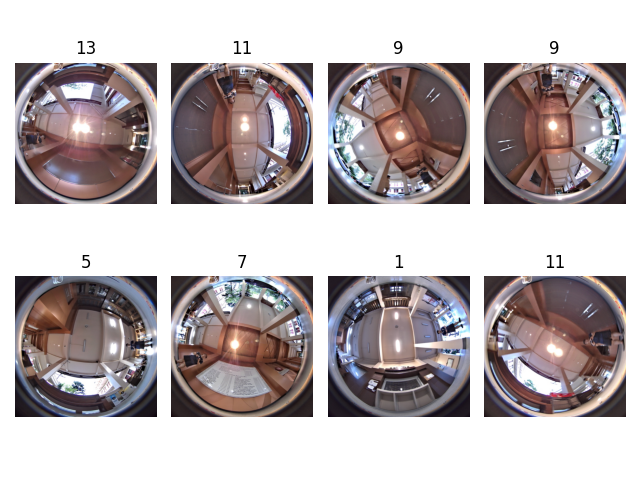

In [10]:
visualize_batch(train_batch, train_class, "train")

In [11]:
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

### Model Assembling

In [12]:
netvlad_config = {
    "num_clusters": 50,
    "desc_dim": 512,            # Up to the Feature Extraction Module
    "alpha": 100.0,
    "normalize_input": True,
}
model = VPRModel(
    feature_extractor=Resnet18Encoder(fine_tuning=False),
    clustering=NetVLAD(**netvlad_config)
)
model = model.to("cuda")

[RESNET18] Output Dim Size: 512
NetVLAD Module initialized !
 - self.num_clusters : 50
 - self.dim : 512
 - self.alpha : 100.0
 - self.normalize_input : True


### Criterion (Loss Function)

In [13]:
criterion = HardTripletLoss()

---

### Trainer Setup

In [14]:
# Configuration
config = {
    "run_name": "default",
    "start_time": "",
    "training_epoch": 20
}

In [15]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    weight_decay=0.001,
    momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)

In [16]:
trainer = Trainer(
    dataset,
    model,
    criterion,
    optimizer,
    scheduler,
    config,
)

Run Name : resnet18_NetVLAD50_ISL2_LabLiftToiletFisheye_14-Mar-2024_15-18-39


### Training Here !

In [ ]:
trainer.train()

==> Epoch 0 Training: 100%|██████████| 27/27 [00:06<00:00,  4.11 batch/s, batch_idx=26, epoch_idx=0, loss=0.0966]


Validating epoch 0



==> Epoch 1 Training: 100%|██████████| 27/27 [00:05<00:00,  4.83 batch/s, batch_idx=26, epoch_idx=1, loss=0.0976]


Validating epoch 1



==> Epoch 2 Training: 100%|██████████| 27/27 [00:05<00:00,  4.81 batch/s, batch_idx=26, epoch_idx=2, loss=0.0979]


Validating epoch 2



==> Epoch 3 Training: 100%|██████████| 27/27 [00:05<00:00,  4.86 batch/s, batch_idx=26, epoch_idx=3, loss=0.0975]


Validating epoch 3



==> Epoch 4 Training: 100%|██████████| 27/27 [00:05<00:00,  4.89 batch/s, batch_idx=26, epoch_idx=4, loss=0.0985]


Validating epoch 4



==> Epoch 5 Training: 100%|██████████| 27/27 [00:05<00:00,  4.88 batch/s, batch_idx=26, epoch_idx=5, loss=0.0999]


Validating epoch 5



==> Epoch 6 Training: 100%|██████████| 27/27 [00:05<00:00,  4.83 batch/s, batch_idx=26, epoch_idx=6, loss=0]


Validating epoch 6



==> Epoch 7 Training: 100%|██████████| 27/27 [00:05<00:00,  4.81 batch/s, batch_idx=26, epoch_idx=7, loss=0]


Validating epoch 7



==> Epoch 8 Training: 100%|██████████| 27/27 [00:05<00:00,  4.77 batch/s, batch_idx=26, epoch_idx=8, loss=0.0973]


Validating epoch 8



==> Epoch 9 Training: 100%|██████████| 27/27 [00:05<00:00,  4.87 batch/s, batch_idx=26, epoch_idx=9, loss=0]


Validating epoch 9



==> Epoch 10 Training: 100%|██████████| 27/27 [00:05<00:00,  4.95 batch/s, batch_idx=26, epoch_idx=10, loss=0.0702]


Validating epoch 10



==> Epoch 11 Training: 100%|██████████| 27/27 [00:05<00:00,  4.95 batch/s, batch_idx=26, epoch_idx=11, loss=0.0822]


Validating epoch 11



==> Epoch 12 Training: 100%|██████████| 27/27 [00:05<00:00,  4.94 batch/s, batch_idx=26, epoch_idx=12, loss=0.0942]


Validating epoch 12



==> Epoch 13 Training: 100%|██████████| 27/27 [00:05<00:00,  4.84 batch/s, batch_idx=26, epoch_idx=13, loss=0.108]


Validating epoch 13



==> Epoch 14 Training: 100%|██████████| 27/27 [00:05<00:00,  4.86 batch/s, batch_idx=26, epoch_idx=14, loss=0]


Validating epoch 14



==> Epoch 15 Training: 100%|██████████| 27/27 [00:05<00:00,  4.90 batch/s, batch_idx=26, epoch_idx=15, loss=0.105]


Validating epoch 15



==> Epoch 16 Training: 100%|██████████| 27/27 [00:05<00:00,  4.80 batch/s, batch_idx=26, epoch_idx=16, loss=0.0917]


Validating epoch 16



==> Epoch 17 Training: 100%|██████████| 27/27 [00:05<00:00,  4.86 batch/s, batch_idx=26, epoch_idx=17, loss=0.119]


Validating epoch 17



==> Epoch 18 Training: 100%|██████████| 27/27 [00:05<00:00,  4.93 batch/s, batch_idx=26, epoch_idx=18, loss=0]


Validating epoch 18



==> Epoch 19 Training: 100%|██████████| 27/27 [00:05<00:00,  4.88 batch/s, batch_idx=26, epoch_idx=19, loss=0]


Validating epoch 19



==> Epoch 19 Validating:  67%|██████▋   | 2/3 [00:00<00:00,  6.05batch/s]